In [ ]:
! pip install numpyro corner healpy einops reproject

In [ ]:
# run only if LaTeX is needed
! sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

In [2]:
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.append(r'/content/drive/Othercomputers/My MacBook Pro/gce-prob-prog/')
%cd /content/drive/Othercomputers/My MacBook Pro/gce-prob-prog/notebooks

Mounted at /content/drive
/content/drive/Othercomputers/My MacBook Pro/gce-prob-prog/notebooks


In [3]:
%reload_ext autoreload
%autoreload 2

import os, sys
sys.path.append("..")

import numpy as np
import healpy as hp
from astropy.io import fits
from pprint import pprint
from tqdm import tqdm
import pickle
import corner

import jax
import numpyro.handlers as handlers

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('matplotlibrc')

In [4]:
from models.poissonian_cart import GCEPyModel

In [5]:
ebinmodel_gcepy = GCEPyModel()

In [6]:
output_dir = '../output/posteriors'

## 1. fit
### 1.1 single energy

In [ ]:
for ie in range(ebinmodel_gcepy.mask.shape[0]):
    svi_results = ebinmodel_gcepy.fit_SVI_at_bin(
        ie=ie,
        rng_key=jax.random.PRNGKey(42),
        n_steps=10000,
        guide="iaf",
        lr=1e-4,
        num_flows=5,
        hidden_dims=[256, 256],
        num_particles=8,
    )
    samples = ebinmodel_gcepy.get_svi_samples(num_samples=50000, expand_samples=True)
    pickle.dump((samples, svi_results), open(f'{output_dir}/compare_gcepy/gcepy_svi_ie{ie}.p', 'wb'))

100%|██████████| 10000/10000 [00:19<00:00, 508.85it/s, init loss: 107445.3359, avg. loss [9501-10000]: 28350.9199]


In [ ]:
s = pickle.load(open(f'{output_dir}/compare_gcepy/gcepy_svi_ie0.p', 'rb'))[0]

### 1.2 full

In [ ]:
svi_results = ebinmodel_gcepy.fit_SVI(
    rng_key=jax.random.PRNGKey(422),
    num_flows=5, hidden_dims=[128, 128],
    n_steps=20000, lr=5e-5, num_particles=8,
    ebin='all',
    error_mode='ll',
)

 40%|████      | 8021/20000 [01:10<01:33, 128.36it/s, init loss: 1275798272.0000, avg. loss [7001-8000]: 1877898.2500]

In [ ]:
svi_results.losses[-1]

In [ ]:
samples = ebinmodel_gcepy.get_svi_samples(num_samples=50000, expand_samples=True)
pickle.dump((samples, svi_results), open(f'{output_dir}/compare_gcepy/gcepy_svi_full_errll_par8_2.p', 'wb'))

1877752.2

## 2. Plotting

In [ ]:
ebin_edges = np.array([0.275, 0.357, 0.464, 0.603, 0.784, 1.02, 1.32, 1.72,
                       2.24, 2.91, 3.78, 4.91, 10.8, 23.7, 51.9])
ebin_centers = (ebin_edges[1:] + ebin_edges[:-1]) / 2

### 2.1 single energy

<ipython-input-60-8c0dd0d32b8d>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  f'ie{ie}' : mpl.cm.get_cmap('rainbow')(ie/(ie_tot-1))


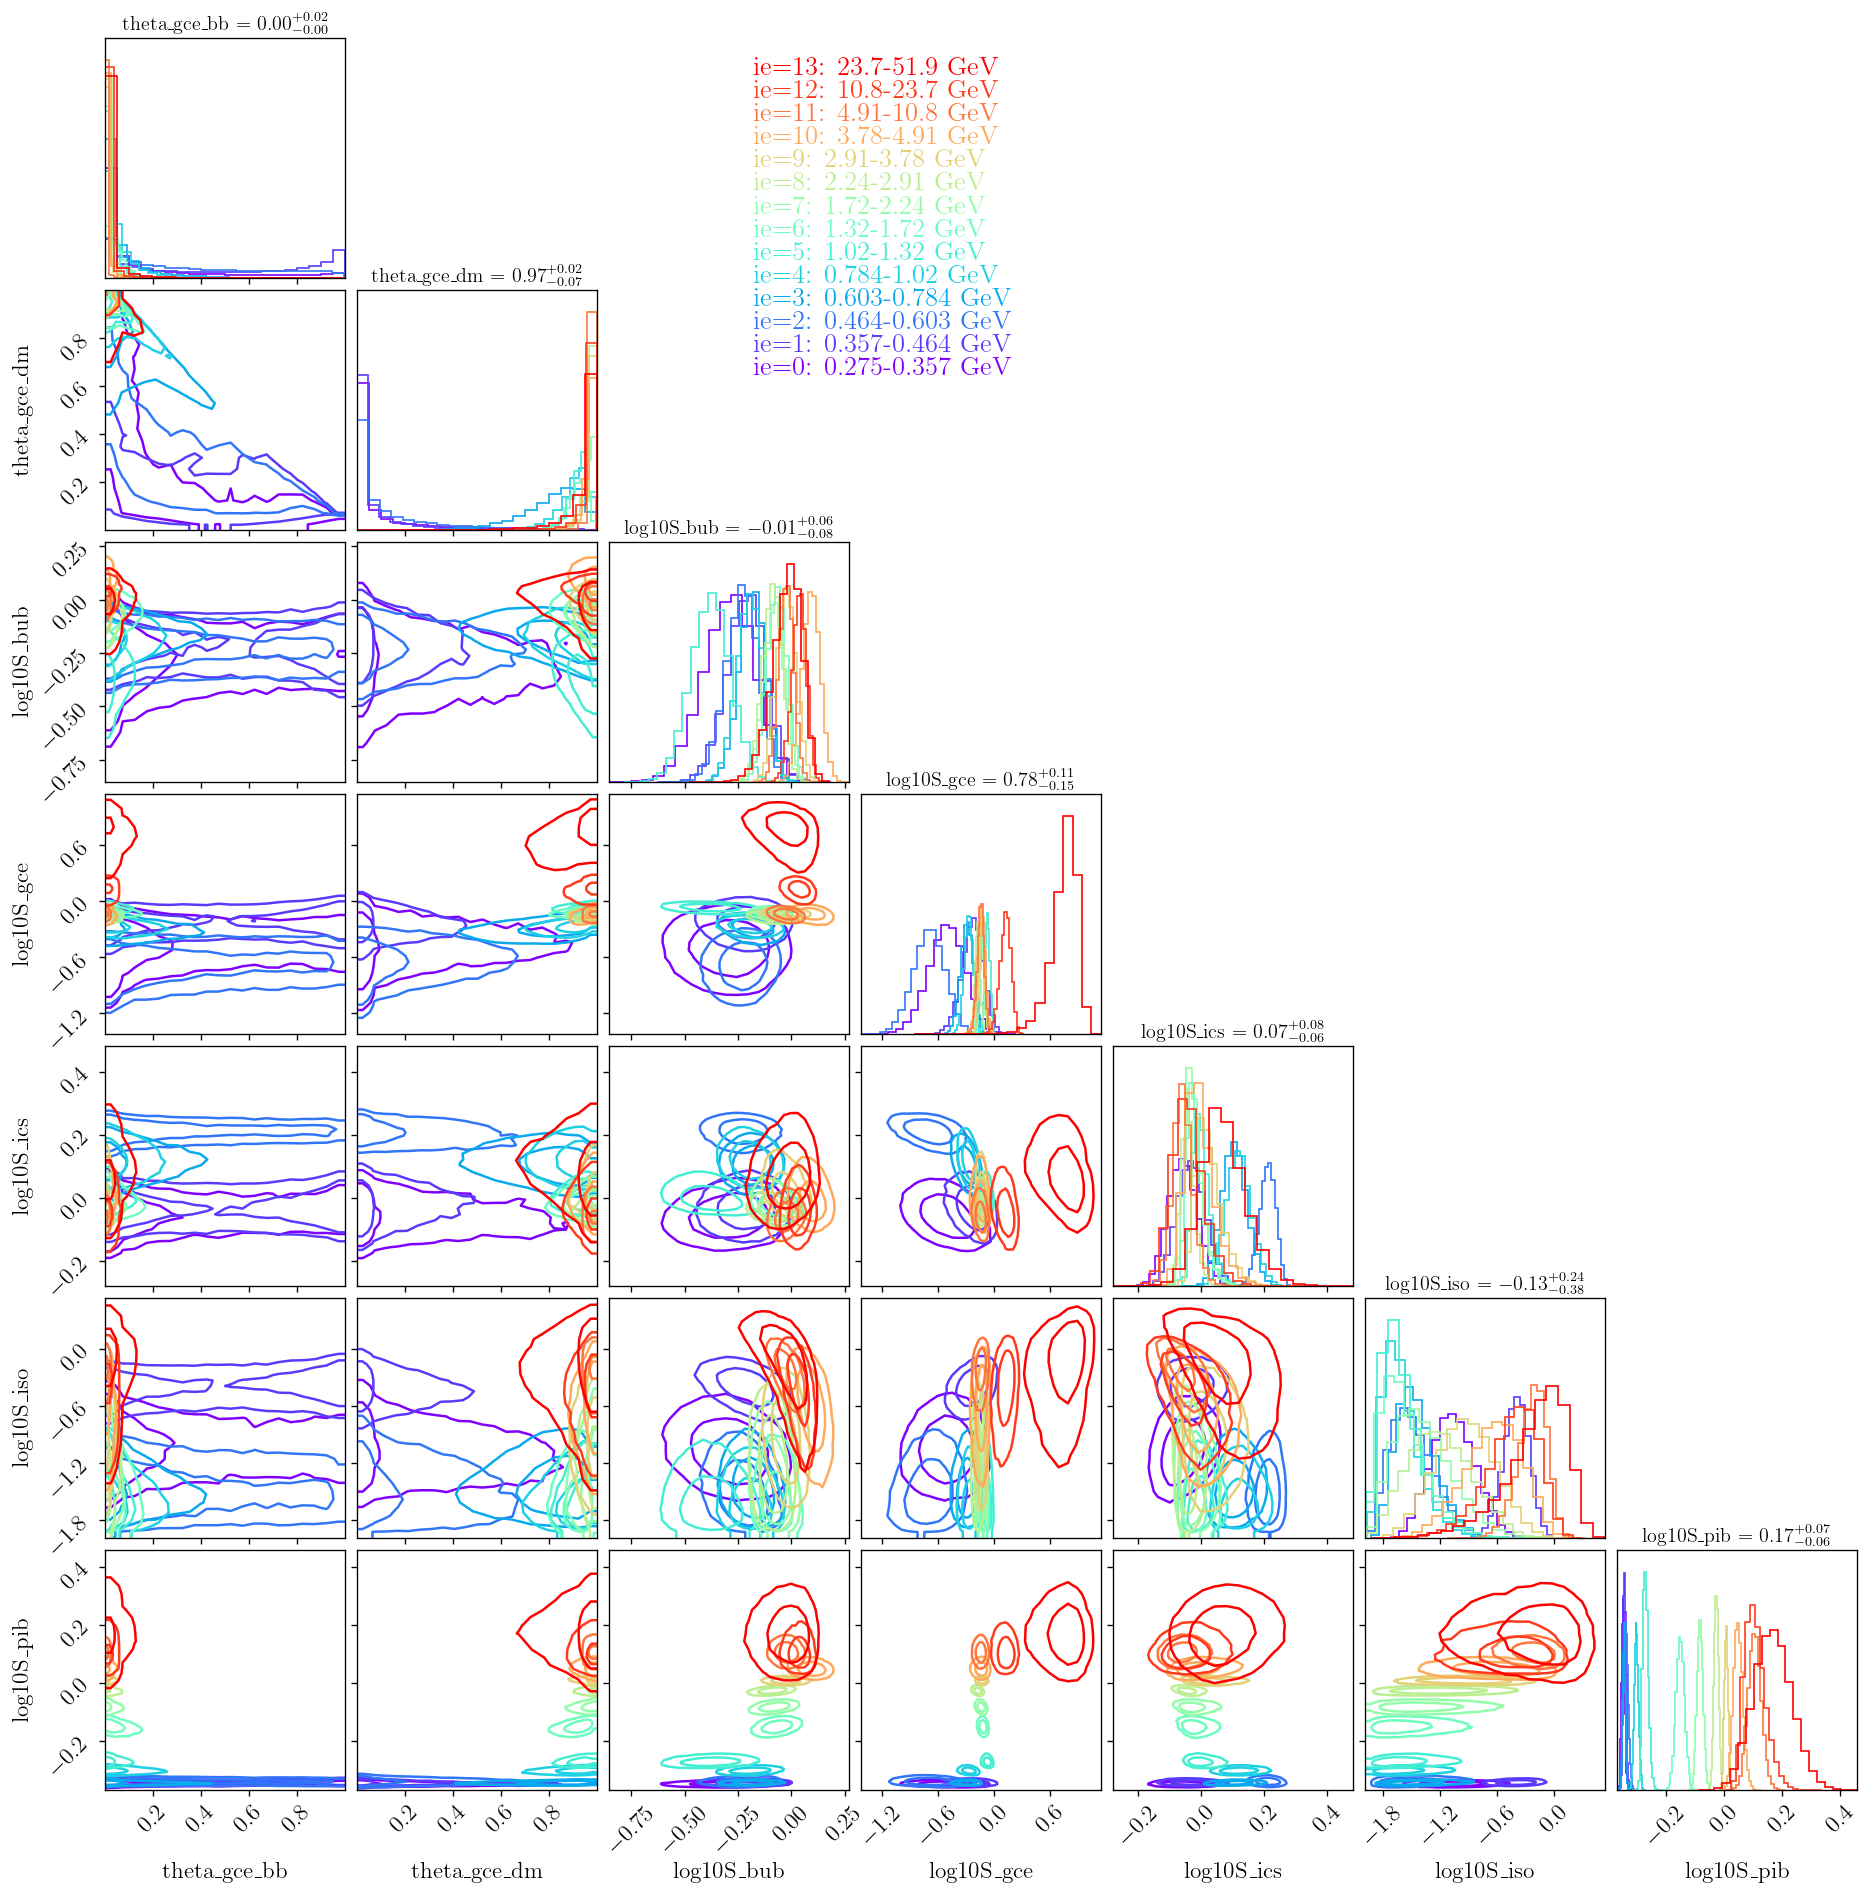

In [ ]:
samples_dict = {}
ie_tot = 14
for ie in range(ie_tot):
    s = pickle.load(open(f'{output_dir}/compare_gcepy/gcepy_svi_ie{ie}.p', 'rb'))[0]
    s['theta_gce_bulges'] = s['theta_gce_bbp'] + s['theta_gce_bb'] + s['theta_gce_x']
    samples_dict[f'ie{ie}'] = s

colors_dict = {
    f'ie{ie}' : mpl.cm.get_cmap('rainbow')(ie/(ie_tot-1))
    for ie in range(ie_tot)
}

plot_var_names = [
    'theta_gce_bb', 'theta_gce_dm',
    'log10S_bub', 'log10S_gce', 'log10S_ics', 'log10S_iso', 'log10S_pib',
]

n_bins_1d = 30
bins_1d_arr = []
for vn in plot_var_names:
    vmin = np.min([np.min(s[vn]) for _, s in samples_dict.items()])
    vmax = np.max([np.max(s[vn]) for _, s in samples_dict.items()])
    bins_1d_arr.append(np.linspace(vmin, vmax, n_bins_1d + 1))

figure = None
for ie, (samples_name, samples) in enumerate(samples_dict.items()):
    color = mpl.colors.to_hex(colors_dict[samples_name])
    figure = corner.corner(
        samples,
        bins_1d_arr=bins_1d_arr,
        var_names=plot_var_names,
        show_titles=True,
        title_kwargs={"fontsize": 12},
        levels = [0.68, 0.95],
        color = color,
        plot_contours=True,
        fill_contours=False,
        plot_density=False,
        plot_datapoints=False,
        fig=figure,
    )
    #figure.text(0.4, 0.8+0.012*ie, , fontsize=16, color=color)

figure.legend(
    [mpl.lines.Line2D([0], [0], color=c) for k, c in colors_dict.items()],
    [f'ie={ie}: {ebin_edges[ie]}-{ebin_edges[ie+1]} GeV' for ie in colors_dict.items()],
    loc=(0.4, 0.9)
)

# ndim = len(plot_var_names)
# axs = np.array(figure.axes).reshape((ndim, ndim))

# MAP_estimates, _ = pickle.load(open(f'{output_dir}/check_SVI/ebin10_MAP.p', 'rb'))

# for i, v in enumerate(plot_var_names):
#     axs[i,i].axvline(MAP_estimates[v], color='k')
    
# for ri in range(ndim):
#     for ci in range(ri):
#         axs[ri,ci].plot(MAP_estimates[plot_var_names[ci]], MAP_estimates[plot_var_names[ri]], '*', color='k', ms=10)

plt.savefig('../output/posteriors/plots/gcepy_noprior.pdf')

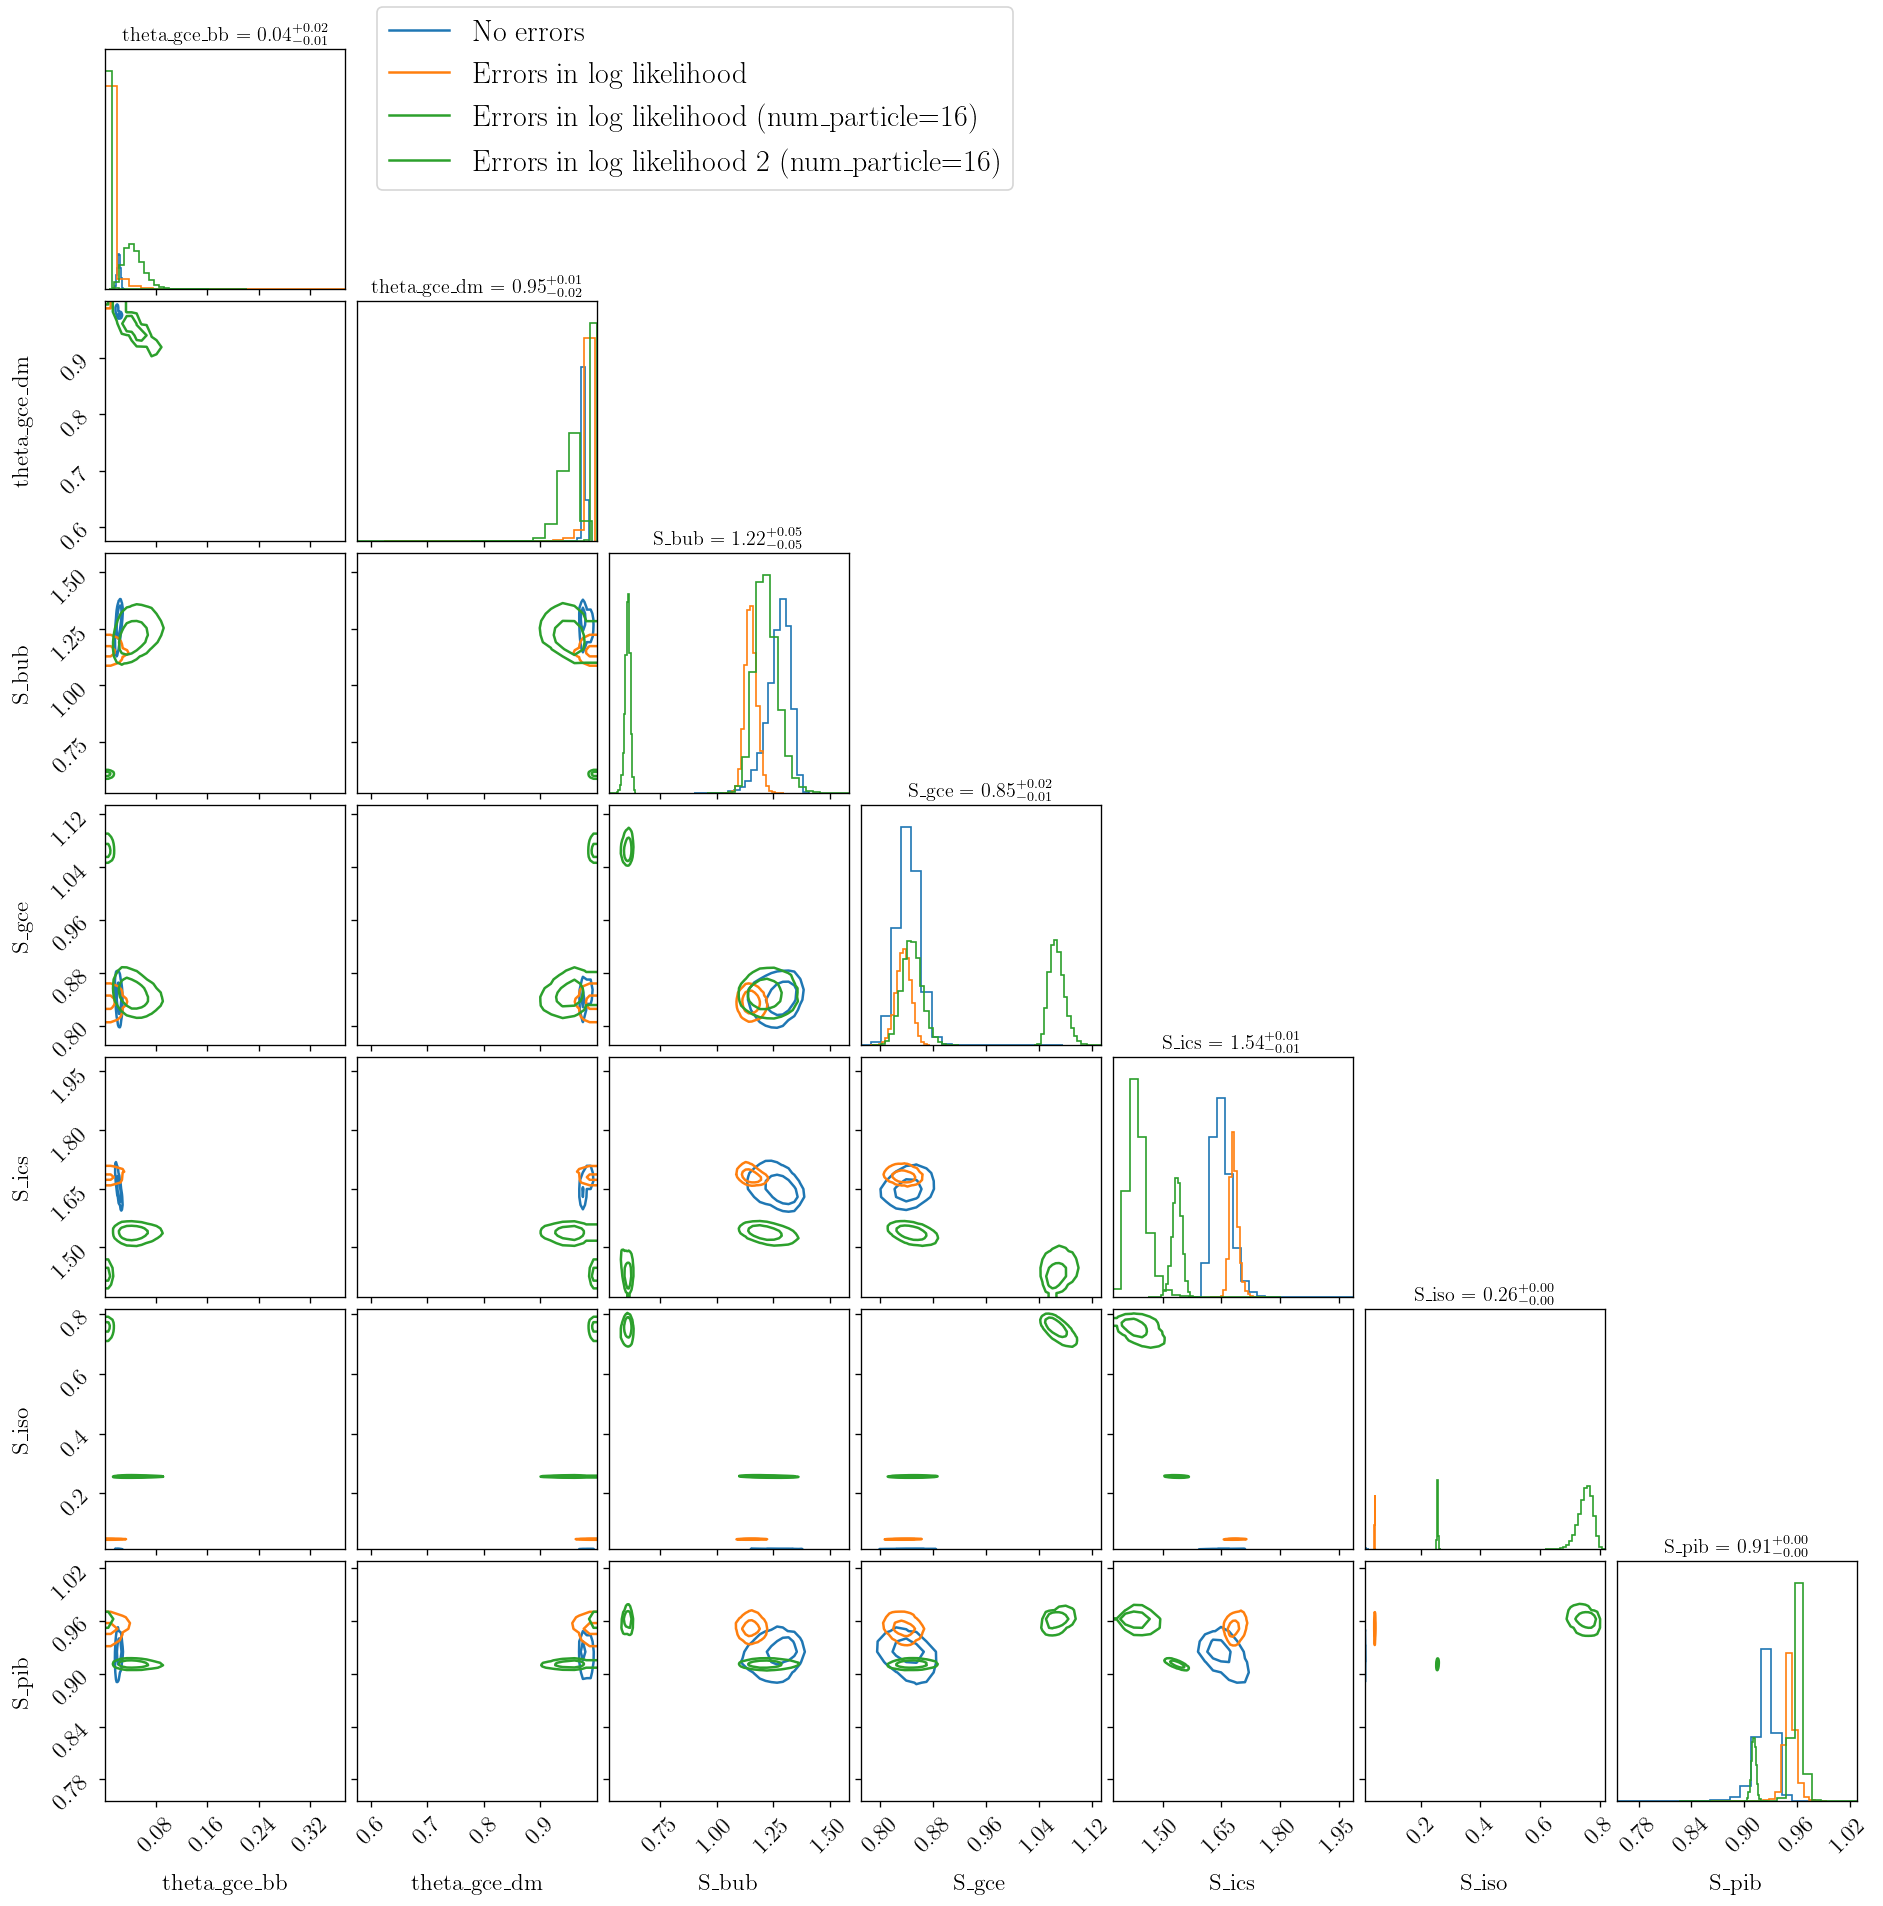

In [ ]:
samples_dict = {
    'noerr' : pickle.load(open(f'{output_dir}/compare_gcepy/gcepy_svi_full.p', 'rb'))[0],
    'errll' : pickle.load(open(f'{output_dir}/compare_gcepy/gcepy_svi_full_errll.p', 'rb'))[0],
    'errll_par16' : pickle.load(open(f'{output_dir}/compare_gcepy/gcepy_svi_full_errll_par16.p', 'rb'))[0],
    'errll_par16_2' : pickle.load(open(f'{output_dir}/compare_gcepy/gcepy_svi_full_errll_par16_2.p', 'rb'))[0],
}
colors_dict = {
    'noerr' : 'C0',
    'errll' : 'C1',
    'errll_par16' : 'C2',
    'errll_par16_2' : 'C2',
}
names_dict = {
    'noerr' : 'No errors',
    'errll' : 'Errors in log likelihood',
    'errll_par16' : 'Errors in log likelihood (num_particle=16)',
    'errll_par16_2' : 'Errors in log likelihood 2 (num_particle=16)',
}
plot_var_names = [
    'theta_gce_bb', 'theta_gce_dm',
    'S_bub', 'S_gce', 'S_ics', 'S_iso', 'S_pib',
]

n_bins_1d = 30
bins_1d_arr = []
for vn in plot_var_names:
    vmin = np.min([np.min(s[vn]) for _, s in samples_dict.items()])
    vmax = np.max([np.max(s[vn]) for _, s in samples_dict.items()])
    bins_1d_arr.append(np.linspace(vmin, vmax, n_bins_1d + 1))

figure = None
for ie, (samples_name, samples) in enumerate(samples_dict.items()):
    color = mpl.colors.to_hex(colors_dict[samples_name])
    figure = corner.corner(
        samples,
        bins_1d_arr=bins_1d_arr,
        var_names=plot_var_names,
        show_titles=True,
        title_kwargs={"fontsize": 12},
        levels = [0.68, 0.95],
        color = color,
        plot_contours=True,
        fill_contours=False,
        plot_density=False,
        plot_datapoints=False,
        fig=figure,
    )
    #figure.text(0.4, 0.8+0.012*ie, samples_name, fontsize=18, color=color)

figure.legend(
    [mpl.lines.Line2D([0], [0], color=c) for k, c in colors_dict.items()],
    [names_dict[k] for k, c in colors_dict.items()],
    loc=(0.2, 0.9)
)

# ndim = len(plot_var_names)
# axs = np.array(figure.axes).reshape((ndim, ndim))

# MAP_estimates, _ = pickle.load(open(f'{output_dir}/check_SVI/ebin10_MAP.p', 'rb'))

# for i, v in enumerate(plot_var_names):
#     axs[i,i].axvline(MAP_estimates[v], color='k')
    
# for ri in range(ndim):
#     for ci in range(ri):
#         axs[ri,ci].plot(MAP_estimates[plot_var_names[ci]], MAP_estimates[plot_var_names[ri]], '*', color='k', ms=10)

plt.savefig('../output/posteriors/plots/gcepy_full.pdf')

## Debug

In [ ]:
with handlers.seed(rng_seed=42):
    ll = ebinmodel_gcepy.model_full(None)
    print(ll)

None
